In [136]:
import json
import scipy
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [16]:
%load_ext autoreload
%autoreload 2

In [45]:
from typing import Callable, Sequence

import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import torch.optim as optim
import torchvision

In [6]:
import sys
src_path = ".."
if src_path not in sys.path:
    sys.path.append(src_path)

In [103]:
from src.diffusion_model import DiffusionUNet
import src.diffusion_schedulers as diffusion_schedulers
from src.train import train as train_model
from src.sample import ddim_sampler
from src.utils import tensor_to_pil, load_checkpoint, load_model

In [11]:
dataset_dir = "../datasets/flowers_2/"

First we will convert the image file into a tensor

In [12]:
def transforms():
    """ 
    ToTensor: 
        Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] 
        to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

    Resize:
        Resize the input image to the given size. 
        If the image is torch Tensor, it is expected to have […, H, W] shape
    """
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(
            (64, 64), 
            interpolation=torchvision.transforms.functional.InterpolationMode.BILINEAR
        ),
        torchvision.transforms.ToTensor(),
    ])

In [20]:
train_dataset = torchvision.datasets.Flowers102(dataset_dir, split="train", transform=transforms(), download=True)
valid_dataset = torchvision.datasets.Flowers102(dataset_dir, split="val", transform=transforms(), download=True)
test_dataset = torchvision.datasets.Flowers102(dataset_dir, split="test", transform=transforms(), download=True)

In [21]:
len(train_dataset), len(valid_dataset), len(test_dataset), 

(1020, 1020, 6149)

Text(0.5, 1.0, 'noise')

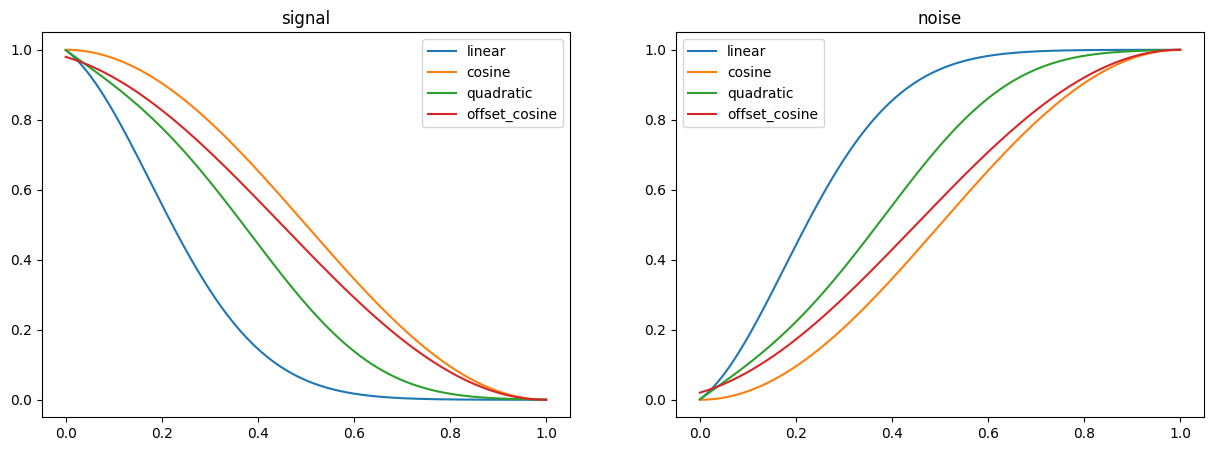

In [37]:
steps = 1000
diffusion_times = np.linspace(0.0, 1.0, steps)
linrates = diffusion_schedulers.linear(0.001, 0.02, diffusion_times)
quadratic = diffusion_schedulers.quadratic(0.001, 0.02, diffusion_times)
cosrates = diffusion_schedulers.cosine(diffusion_times, offset=0)
offset_cosine = diffusion_schedulers.cosine(diffusion_times, offset=0.1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
ax1.plot(np.linspace(0, 1, steps), linrates, label="linear")
ax1.plot(np.linspace(0, 1, steps), cosrates, label="cosine")
ax1.plot(np.linspace(0, 1, steps), quadratic, label="quadratic")
ax1.plot(np.linspace(0, 1, steps), offset_cosine, label="offset_cosine")
ax1.legend()
ax1.set_title("signal")

ax2.plot(np.linspace(0, 1, steps), 1 - linrates, label="linear")
ax2.plot(np.linspace(0, 1, steps), 1 - cosrates, label="cosine")
ax2.plot(np.linspace(0, 1, steps), 1 - quadratic, label="quadratic")
ax2.plot(np.linspace(0, 1, steps), 1 - offset_cosine, label="offset_cosine")
ax2.legend()
ax2.set_title("noise")

In [40]:
def image_corruption(
    input_image: torch.Tensor, 
    max_steps: int,
    schedule: Callable[list[float], list[float]]
) -> torch.Tensor:
    """ Returns image corrupted at different time steps """
    diffusion_times = np.linspace(0.0, 1.0, num=max_steps)
    alpha_bars = torch.Tensor(schedule(diffusion_times)).view(max_steps, 1, 1, 1)
    input_repeated = input_image.repeat((max_steps, 1, 1, 1))
    gaussian_noise = torch.randn((max_steps, input_image.shape[0], input_image.shape[1], input_image.shape[2]))
    images = torch.sqrt(alpha_bars) * input_repeated + torch.sqrt(1 - alpha_bars) * gaussian_noise
    return torch.cat((torch.unsqueeze(input_image, 0), images))

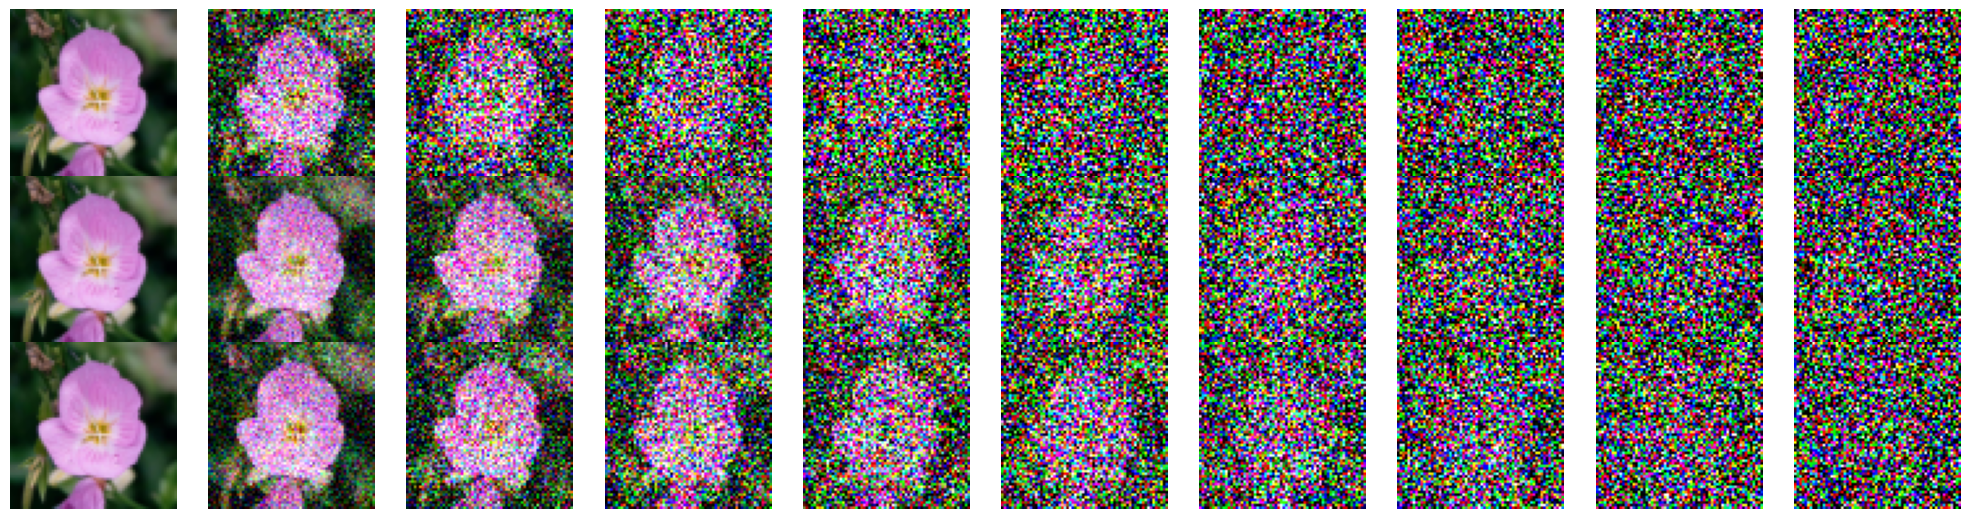

In [43]:
steps = 1000
test_batch_data = test_dataset[0]
linear_corrupted = image_corruption(test_batch_data[0], steps, lambda s: diffusion_schedulers.linear(0.0001, 0.02, s))
quadratic_corrupted = image_corruption(test_batch_data[0], steps, lambda s: diffusion_schedulers.quadratic(0.0001, 0.02, s))
cosine_corrupted = image_corruption(test_batch_data[0], steps, lambda s: diffusion_schedulers.cosine(s))
f, ax = plt.subplots(3, int(steps / 100), sharey=True, figsize=(20, 5))
for i in range(len(ax[0])):
    img = linear_corrupted[i * 100]
    ax[0][i].imshow(tensor_to_pil(img))
    ax[0][i].axis("off")

    img = quadratic_corrupted[i * 100]
    ax[1][i].imshow(tensor_to_pil(img))
    ax[1][i].axis("off")

    img = cosine_corrupted[i * 100]
    ax[2][i].imshow(tensor_to_pil(img))
    ax[2][i].axis("off")

    
f.tight_layout(pad=0, h_pad=0, w_pad=0)

# Model Definition

In [46]:
model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)   

In [47]:
model.config()

{'in_channels': 3,
 'out_channels': 3,
 'base_channels': 32,
 'image_resolution': 64,
 'num_res_blocks': 2,
 'channel_multipliers': [1, 2, 4, 8],
 'attention_resolutions': [16],
 'resample_with_conv': True,
 'time_emb_dim': 128,
 'dropout': 0.1}

In [48]:
batch_size = 4
x = torch.randn(batch_size, 3, 64, 64)
t = torch.randn((batch_size,))

print("input", x.shape, "noise shape", t.shape)
y = model(x, t)
print("output", y.shape)

input torch.Size([4, 3, 64, 64]) noise shape torch.Size([4])
output torch.Size([4, 3, 64, 64])


## Training

In [59]:
epochs = 5
batch_size = 4
model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
min_rate = 0.02
max_rate = 0.95
timesteps = 1000
diffusion_times = np.linspace(0, 1, timesteps)
alpha_bars = diffusion_schedulers.cosine(diffusion_times, offset=0.008)
signal_rates = torch.tensor(np.sqrt(alpha_bars), dtype=torch.float)
noise_rates = torch.tensor(np.sqrt(1 - alpha_bars), dtype=torch.float)

In [60]:
train_dataloader = torch_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = torch_data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [124]:
model = train_model(
    model,
    train_dataloader, 
    optimizer, 
    signal_rates, 
    noise_rates, 
    timesteps, 
    valid_dataloader, 
    epochs=epochs, 
    batch_size=batch_size, 
    checkpoint_path="../data/checkpoint.pt"
)

100%|███████████████████████████████████████████████████| 255/255 [01:37<00:00,  2.62it/s]


Epoch 0: Average Loss 0.04637


100%|███████████████████████████████████████████████████| 255/255 [00:31<00:00,  8.10it/s]


Validation Loss: 0.04580
Saving checkpoint for epoch 1...
New best validation loss: 0.04580
Saving best model to ../data/checkpoint.pt...


100%|███████████████████████████████████████████████████| 255/255 [01:40<00:00,  2.54it/s]


Epoch 1: Average Loss 0.04265


100%|███████████████████████████████████████████████████| 255/255 [00:33<00:00,  7.69it/s]


Validation Loss: 0.04213
Saving checkpoint for epoch 2...
New best validation loss: 0.04213
Saving best model to ../data/checkpoint.pt...


100%|███████████████████████████████████████████████████| 255/255 [01:38<00:00,  2.58it/s]


Epoch 2: Average Loss 0.04111


100%|███████████████████████████████████████████████████| 255/255 [00:31<00:00,  8.03it/s]


Validation Loss: 0.04067
Saving checkpoint for epoch 3...
New best validation loss: 0.04067
Saving best model to ../data/checkpoint.pt...


100%|███████████████████████████████████████████████████| 255/255 [01:41<00:00,  2.52it/s]


Epoch 3: Average Loss 0.04414


100%|███████████████████████████████████████████████████| 255/255 [00:32<00:00,  7.97it/s]


Validation Loss: 0.04377
Saving checkpoint for epoch 4...


100%|███████████████████████████████████████████████████| 255/255 [01:39<00:00,  2.57it/s]


Epoch 4: Average Loss 0.03910


100%|███████████████████████████████████████████████████| 255/255 [00:31<00:00,  8.08it/s]

Validation Loss: 0.04406
Saving checkpoint for epoch 5...


In [125]:
best_model = DiffusionUNet(
    in_channels=3,
    out_channels=3,
    base_channels=32,
    image_resolution=64,
    num_res_blocks=2,
    channel_multipliers=[1, 2, 4, 8],
    attention_resolutions=[16],
    dropout=0.1,
    resample_with_conv=True,
    time_emb_dim=128,
)
best_model.load_state_dict(torch.load("../data/checkpoint.pt"))

<All keys matched successfully>

In [126]:
sampled_image = ddim_sampler(
    best_model, 
    noise_rates, 
    signal_rates, 
    timesteps,
    step_size=10, 
    batch_size=1
)

Sampling: 100it [00:03, 33.17it/s]

Final step, no noise added


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

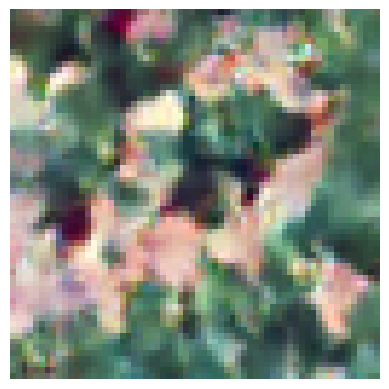

In [127]:
plt.figure()
img = sampled_image[0].permute(1, 2, 0).numpy()
plt.imshow(img)
plt.axis('off')